# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings

In [ ]:
# import utility functions
import src.utils as util
reload(util)

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [3]:
# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [ ]:
# load transaction dataset
df_patients = pd.read_csv(path_patients)
df_admissions = pd.read_csv(path_admissions)
df_diagnoses_icd = pd.read_csv(path_diagnoses_icd)
df_labevents = pd.read_csv(path_labevents)
df_microbiologyevents = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd = pd.read_csv(path_desc_icd)
df_desc_labitems = pd.read_csv(path_desc_labitems)
df_desc_items = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [5]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients['DOB'] = pd.to_datetime(df_patients['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents['CHARTTIME'] = pd.to_datetime(df_labevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents['CHARTDATE'] = pd.to_datetime(df_microbiologyevents['CHARTDATE'], format='%Y-%m-%d')
df_microbiologyevents['CHARTTIME'] = pd.to_datetime(df_microbiologyevents['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [6]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd[df_desc_icd.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd['IS_SEPSIS'] = df_diagnoses_icd.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [11]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd[(df_diagnoses_icd['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

#function to save df to csv file
def save_csv(df, filename):
    filepath = Path(filename)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath, index=False)

In [ ]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic = pd.merge(df_admissions, df_patients[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic['AGE'] = ((df_demographic['ADMITTIME'].dt.date - df_demographic['DOB'].dt.date) // 365).dt.days
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic['IS_SEPSIS'] = df_demographic.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd), axis=1)

<Axes: title={'center': 'AGE'}, xlabel='IS_SEPSIS'>

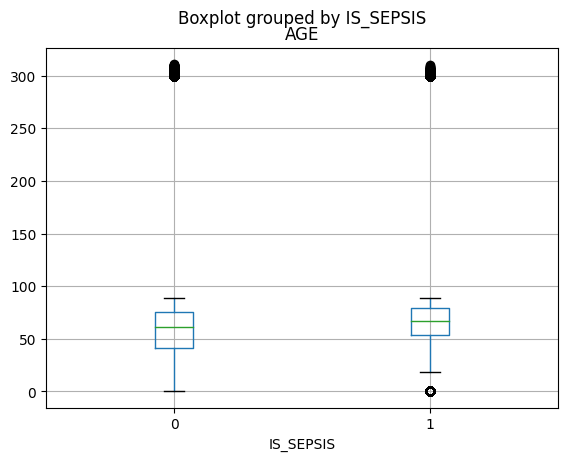

In [14]:
# plotting the age of admissions
df_demographic.boxplot(column=['AGE'], by='IS_SEPSIS')

Load unpivoted labevents dataframe:

In [15]:
# List all Parquet files in the output folder
output_dir = ROOT_DIR / 'data' / 'labevents_transform_sepsis_parquet'
parquet_files = [f'{output_dir}/{file}' for file in os.listdir(output_dir) if file.endswith('.parquet')]

# Read all Parquet files into a list of DataFrames
dfs = [pd.read_parquet(file) for file in parquet_files]

# Concatenate the list of DataFrames into a single DataFrame
df_labevents_sepsis = pd.concat(dfs, ignore_index=True)
df_labevents_sepsis.columns = df_labevents_sepsis.columns.str.upper()

In [ ]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents[df_labevents['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents[pd.to_numeric(df_labevents["HADM_ID"], errors='coerce').notnull()]

df_admissions.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions['ADMITTIME'] = pd.to_datetime(df_admissions['ADMITTIME'])
df_admissions['DISCHTIME'] = pd.to_datetime(df_admissions['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

In [ ]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)
combined_df_hasHADM

## 1.2 Data Exploration

## 1.3 Feature Selection

# 2.Sepsis Risk Predicting Model Implementation

## 2.1 Logistics Regression Model

## 2.2 Random Forest Model

## 2.3 Gradient Boosted Model

## 2.4 LSTM Model

## 2.5 LSTM + Attention Model

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation